In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

### importowanie danych z pliku
* tytuly obrazkow z kotami zaczynaja sie od wielkiej litery
* konwertujemy zdjecia na czarnobiale by nie marnowac pamieci komputera (kolory maja znikomy wplyw na skutecznosc naszej seici neuronowej)
* DATA  - lista z obrazkami 
* LABELS - lista z zerami i jedynkami 0 - pies 1 - kot
* N - ilosc zdjec


In [2]:
DATADIR = os.path.curdir + '/images/images'
np.random.seed(1)
IMG_SIZE = 128
names = []
with os.scandir(DATADIR) as images: 
    for i, img in enumerate(images):
        if cv2.haveImageReader(os.path.join(DATADIR, img.name)) and '.jpg' in img.name:
            names.append(img.name)

### usuwanie nadmiarowych psow

* normalizacja
* normalizowanie rozmiarów zdjec


In [3]:
import os
import shutil
import random

def distribute_train_validation_split(validation_size=0.2):

    random.shuffle(names)

    all_dogs = list(filter(lambda image: image[0].isupper() == False, names))
    all_cats = list(filter(lambda image: image[0].isupper() == True, names))
    
    if len(all_cats)> len(all_dogs):
        all_cats = all_cats[:len(all_dogs)]
    elif len(all_cats)< len(all_dogs):
        all_dogs = all_dogs[:len(all_cats)]
        
    print(len(all_cats), len(all_dogs))
    index_to_split = int(len(all_dogs) - len(all_dogs) * validation_size)
    training_dogs = all_dogs[:index_to_split]
    validation_dogs = all_dogs[index_to_split:]
    training_cats = all_cats[:index_to_split]
    validation_cats = all_cats[index_to_split:]

    shutil.rmtree('./input_for_model')
    os.makedirs('./input_for_model/train/dogs/', exist_ok=True)
    os.makedirs('./input_for_model/train/cats/', exist_ok=True)
    os.makedirs('./input_for_model/test/dogs/', exist_ok=True)
    os.makedirs('./input_for_model/test/cats/', exist_ok=True)

    copy_images_to_dir(training_dogs, './input_for_model/train/dogs')
    copy_images_to_dir(validation_dogs, './input_for_model/test/dogs')
    copy_images_to_dir(training_cats, './input_for_model/train/cats')
    copy_images_to_dir(validation_cats, './input_for_model/test/cats')

def copy_images_to_dir(images_to_copy, destination):
    for image in images_to_copy:
        shutil.copyfile(f'./images/images/{image}', f'{destination}/{image}')

distribute_train_validation_split(0.2)

2394 2394


### wyswietlanie zdjec by "oswoic sie z danymi"

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
# define cnn model
def define_model():
	# load model
	model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [5]:
# define model
model = define_model()

In [6]:
# create data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0  )

In [7]:

train_it = datagen.flow_from_directory('input_for_model/train/',
	class_mode='binary', batch_size=64, target_size=(IMG_SIZE, IMG_SIZE))
test_it = datagen.flow_from_directory('input_for_model/test/',
	class_mode='binary', batch_size=64, target_size=(IMG_SIZE, IMG_SIZE))

Found 3590 images belonging to 2 classes.
Found 1198 images belonging to 2 classes.


Epoch 1/15
57/57 [==============================] - 228s 4s/step - loss: 0.5276 - accuracy: 0.7315 - val_loss: 0.4169 - val_accuracy: 0.8164
Epoch 2/15
57/57 [==============================] - 222s 4s/step - loss: 0.3940 - accuracy: 0.8298 - val_loss: 0.3944 - val_accuracy: 0.8097
Epoch 3/15
57/57 [==============================] - 224s 4s/step - loss: 0.3568 - accuracy: 0.8457 - val_loss: 0.3457 - val_accuracy: 0.8422
Epoch 4/15
57/57 [==============================] - 229s 4s/step - loss: 0.3346 - accuracy: 0.8560 - val_loss: 0.3328 - val_accuracy: 0.8556
Epoch 5/15
57/57 [==============================] - 220s 4s/step - loss: 0.3154 - accuracy: 0.8652 - val_loss: 0.3173 - val_accuracy: 0.8548
Epoch 6/15
57/57 [==============================] - 206s 4s/step - loss: 0.3071 - accuracy: 0.8688 - val_loss: 0.3085 - val_accuracy: 0.8556
Epoch 7/15
57/57 [==============================] - 206s 4s/step - loss: 0.2831 - accuracy: 0.8864 - val_loss: 0.3161 - val_accuracy: 0.8639
Epoch 8/15
57

<AxesSubplot:>

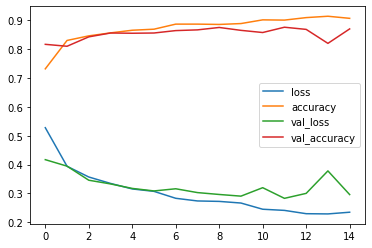

In [8]:

# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=15)
pd.DataFrame(history.history).plot()

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [11]:

# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

19/19 [==============================] - 56s 3s/step - loss: 0.2959 - accuracy: 0.8698
> 86.978


In [13]:
model.save('final_model.h5')

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [12]:
pred_t = model.predict(test_it)

In [ ]:
pred = np.round(pred_t).reshape(-1)

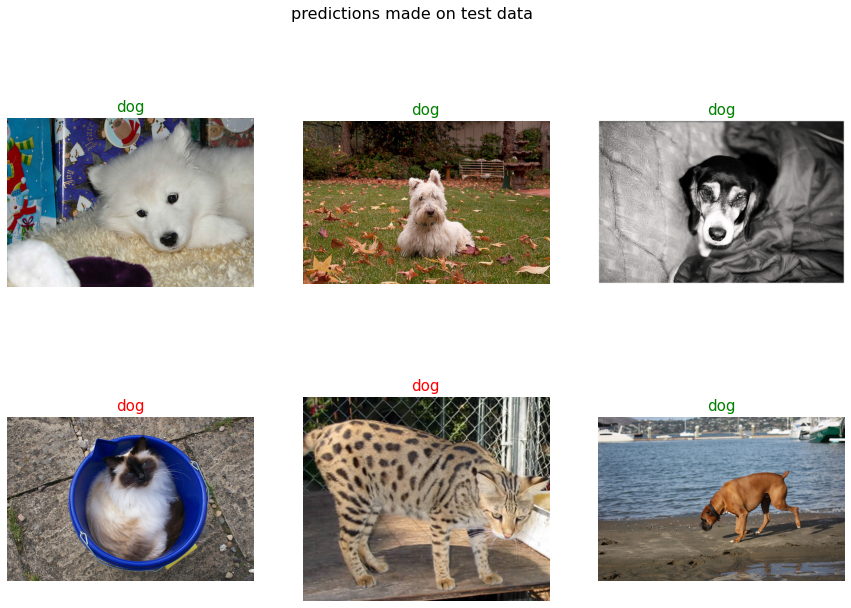

In [65]:

# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image


def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(IMG_SIZE, IMG_SIZE))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# load an image and predict the class


def run_example():
    # load the image
    DIR = './input_for_model/test/'+np.random.choice(['cats', 'dogs'])+'/'
    path = DIR + np.random.choice(os.listdir(DIR))
    img = load_image(path)
    # load model
    model = load_model('final_model.h5')
    # predict the class
    class_names = ['cat', 'dog']
    plt.figure(figsize=(15, 10))
    plt.suptitle('predictions made on test data', fontsize=16)
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)

        DIR = './input_for_model/test/'+np.random.choice(['cats', 'dogs'])+'/'
        path = DIR + np.random.choice(os.listdir(DIR))
        img = load_image(path)
        plt.imshow(load_img(path))
        result = model.predict(img)
        pred_y = class_names[int(result[0][0])]
        if pred_y in DIR:
            color = "green"
        else:
            color = "red"
        plt.title((pred_y), color=color,fontsize=15)
        plt.axis(False)


# entry point, run the example
run_example()


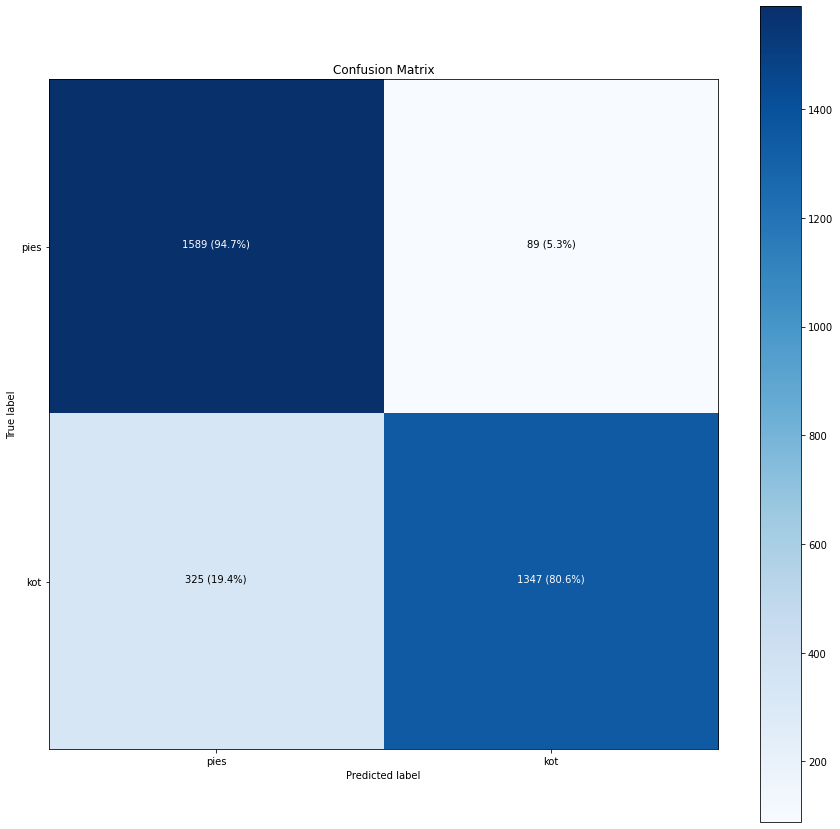

In [ ]:

# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=train_labels, 
                 y_pred = pred)


make_confusion_matrix(y_true=train_labels, 
                      y_pred= np.array(np.round(pred), np.bool8),
                      classes=['pies','kot'],
                      figsize=(15, 15),
                      text_size=10)